In [49]:
import math

import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
from scipy.stats import alpha
from seaborn import scatterplot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression




# Data Cleaning
In the data cleaning process, we need to check the existence of any missing or duplicate values. We also need to check outliers and how they are effecting the dataset.

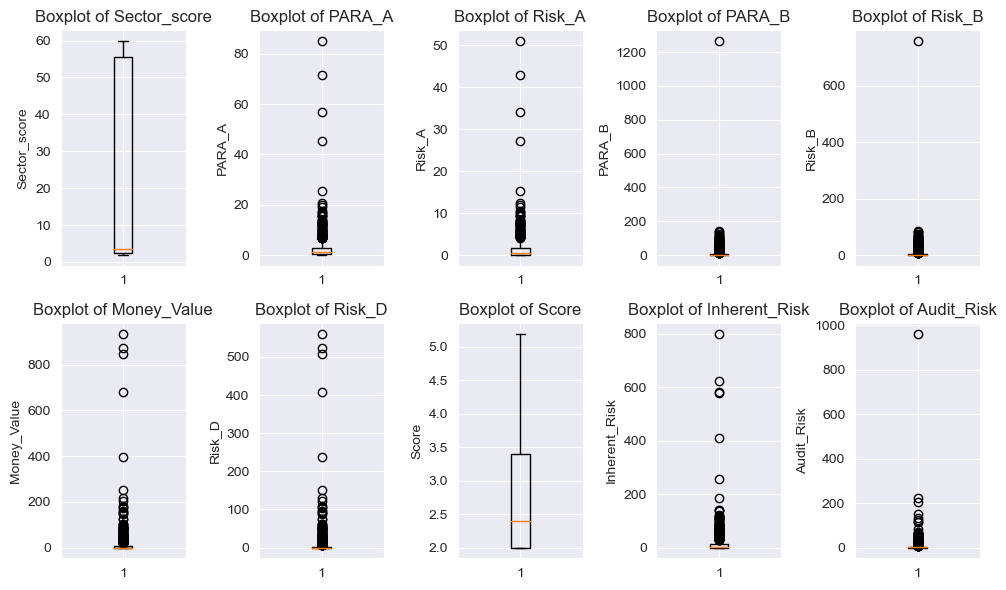

In [2]:
file = pd.read_csv("C:/Users/beryl/OneDrive/Desktop/ML_hw/project2/Data-Audit.csv")

# drop lines with missing values
file.dropna(inplace=True)

# remove duplicates
file = file.drop_duplicates()

# plot the data to check outliers
fig, axes = plt.subplots(2,5, figsize = (10,6))
for ax, col in zip(axes.flat, file.columns[:-1]):
    ax.boxplot(file[col])
    ax.set_title(f'Boxplot of {col}')
    ax.set_ylabel(col)
plt.tight_layout()
plt.show()

In [3]:
print(file[(file['Risk_B']>600) & (file['Audit_Risk'] >800)])

     Sector_score  PARA_A  Risk_A   PARA_B   Risk_B  Money_Value  Risk_D  \
241          2.72    4.28   2.568  1264.63  758.778        58.86  35.316   

     Score  Inherent_Risk  Audit_Risk  Risk  
241    5.2        801.262    961.5144     1  


The plot shows some outliers in each of the categories. One outlier is extreme in Risk_B and Audit_Risk, which should be marked.

# Machine Learning

In [4]:
# split the dataset into half training set and half test set
train_data, test_data = train_test_split(file, test_size=0.5, random_state=13)

# Use Risk column as the predicted outcome and other columns as the predictor
X_train = train_data.drop(columns=['Risk'])
y_train = train_data['Risk']
X_test = test_data.drop(columns=['Risk'])
y_test = test_data['Risk']

## LINEAR PROBABILITY MODEL (LPM)

#### Threshold at 0.5

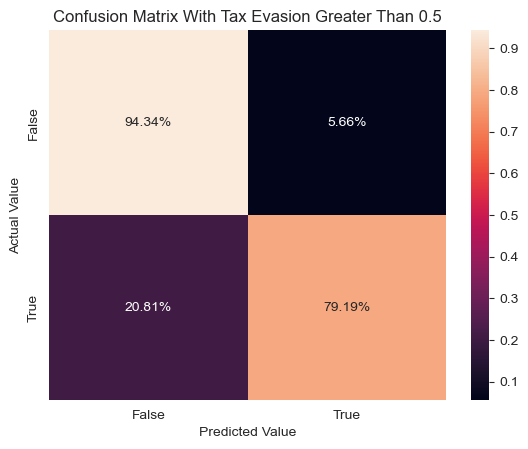

In [5]:
# Train an LPM model with threshold at 0.5
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
lpm_model = sm.OLS(y_train, X_train).fit()
lpm_pred = lpm_model.predict(X_test)
lpm_pred_bin_5 = np.where(lpm_pred > 0.5, 1, 0)

# plot the predicted result in confusion matrix
lpm_conf = confusion_matrix(y_test, lpm_pred_bin_5, normalize='true')
# print(lpm_conf)
heatmap = sns.heatmap(lpm_conf, annot=True, fmt=".2%")
heatmap.set_title("Confusion Matrix With Tax Evasion Greater Than 0.5")
heatmap.set_xlabel("Predicted Value")
heatmap.set_ylabel("Actual Value")
heatmap.xaxis.set_ticklabels(["False", "True"])
heatmap.yaxis.set_ticklabels(["False", "True"])
plt.show()

In [6]:
accuracy = accuracy_score(y_test, lpm_pred_bin_5)
error_5  = 1 - accuracy
print(f'The accuracy of this model is: {accuracy:.3f} with 5% error: {error_5:.3f}')
print(f'with false negative rate: {lpm_conf[0,0]:.3f}, false positive rate: {lpm_conf[0,1]:.3f}, true positive rate: {lpm_conf[1,0]:.3f}, true negative rate: {lpm_conf[1,1]:.3f}')

The accuracy of this model is: 0.881 with 5% error: 0.119
with false negative rate: 0.943, false positive rate: 0.057, true positive rate: 0.208, true negative rate: 0.792


#### Threshold at 0.6

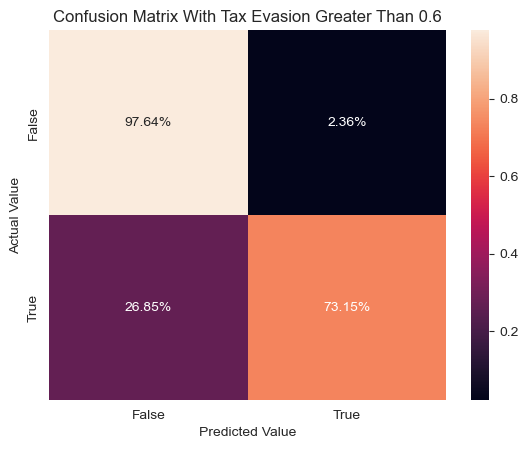

In [7]:
# Train an LPM model with threshold at 0.6
lpm_pred_bin_6 = np.where(lpm_pred > 0.6, 1, 0)

# confusion matrix plot
lpm_conf_6 = confusion_matrix(y_test, lpm_pred_bin_6, normalize='true')
heatmap = sns.heatmap(lpm_conf_6, annot=True, fmt=".2%")
heatmap.set_title("Confusion Matrix With Tax Evasion Greater Than 0.6")
heatmap.set_xlabel("Predicted Value")
heatmap.set_ylabel("Actual Value")
heatmap.xaxis.set_ticklabels(["False", "True"])
heatmap.yaxis.set_ticklabels(["False", "True"])
plt.show()

In [8]:
accuracy_6 = accuracy_score(y_test, lpm_pred_bin_6)
error_6 = 1-accuracy_6
print(f'The accuracy of this model is: {accuracy_6:.3f} with 5% error: {error_6:.3f}')
print(f'with false negative rate: {lpm_conf_6[0,0]:.3f}, false positive rate: {lpm_conf_6[0,1]:.3f}, true positive rate: {lpm_conf_6[1,0]:.3f}, true negative rate: {lpm_conf_6[1,1]:.3f}')

The accuracy of this model is: 0.875 with 5% error: 0.125
with false negative rate: 0.976, false positive rate: 0.024, true positive rate: 0.268, true negative rate: 0.732


### Plotting the ROC Curve
The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR). Instead of just two points (TPR at 0.5 and 0.6), the ROC curve shows the full spectrum of trade-offs between TPR and FPR for all thresholds.

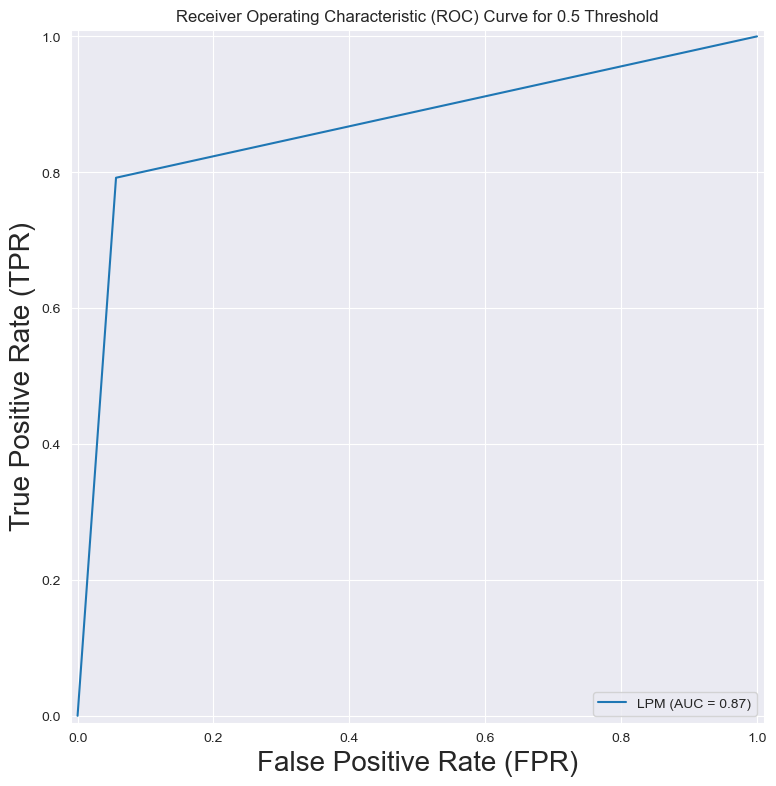

In [17]:
# set up the false positive, true positive and threshold value for the roc curve
def roc(pred_with_threshold):
    fpr_cv, tpr_cv, thresholds = roc_curve(y_test, pred_with_threshold)
    auc_cv = roc_auc_score(y_test, lpm_pred_bin_5)
    roc_curve_cv = RocCurveDisplay(fpr=fpr_cv, tpr=tpr_cv,
                                roc_auc=auc_cv,
                                estimator_name='LPM')
    return roc_curve_cv

# plotting the ROC curve
def plot_roc_curve(roc_curve_cv,threshold):
    fig, ax = plt.subplots(figsize=(9, 9))
    roc_curve_cv.plot(ax=ax)
    ax.set_ylabel("True Positive Rate (TPR)", fontsize=20)
    ax.set_xlabel("False Positive Rate (FPR)", fontsize=20)
    ax.set_title(f"Receiver Operating Characteristic (ROC) Curve for {threshold} Threshold")
    plt.show()

roc_curve_cv_5 = roc(lpm_pred_bin_5)
plot_roc_curve(roc_curve_cv_5, 0.5)

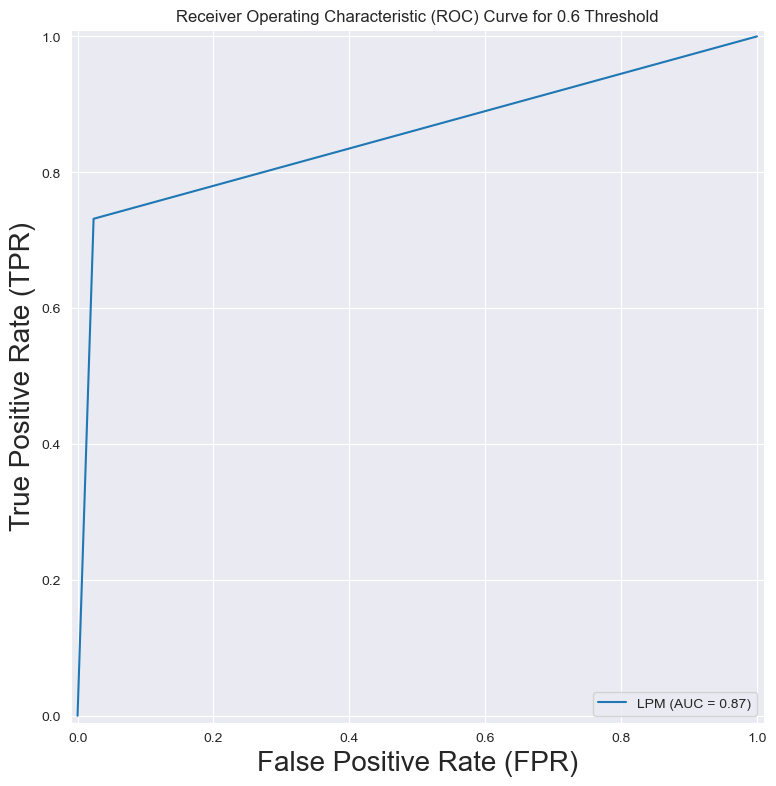

In [19]:
# plot ROC with threshold at 0.6
roc_curve_cv_6 = roc(lpm_pred_bin_6)
plot_roc_curve(roc_curve_cv_6, 0.6)

### Model Selection

False Positive is when someone not evades tax but be predicted as cheated. False Negative is when someone evades the tax but be predicted as not evaded the tax. In the context, False Negative is more important since we want to miss as fewer firms which cheated as possible. Setting the threshold of predicted probability of tax evasion will affect the false negative rate. When we set a lower value of threshold, we categorize firms with lower probability of cheated to be predicted as potential tax evader. In this way, we have lower false negative rate and higher false positive rate. We would like to choose a lower threshold, threshold at 0.5, to achieve a lower false negative rate. This model will provide a better prediction for tax evading.

## KNN MODEL

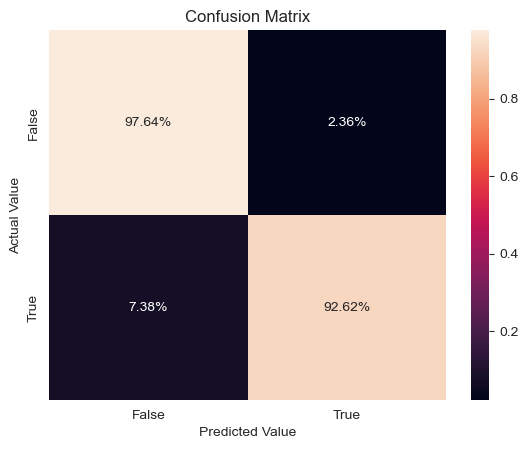

In [40]:
# knn model with 5 neighbors without standardization
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train, y_train)
knn_5_pred = knn_5.predict(X_test)
knn_pred_bin_5 = np.where(knn_5_pred > 0.5, 1, 0)
cm_5 = confusion_matrix(y_test, knn_pred_bin_5, normalize='true')
cm_plt = sns.heatmap(cm_5, annot=True, fmt=".2%")
cm_plt.set_title("Confusion Matrix")
cm_plt.set_xlabel("Predicted Value")
cm_plt.set_ylabel("Actual Value")
cm_plt.xaxis.set_ticklabels(["False", "True"])
cm_plt.yaxis.set_ticklabels(["False", "True"])
plt.show()


In [29]:
# compute the accuracy and error rate
accuracy = accuracy_score(y_test, knn_pred_bin_5)
error_knn_5 = 1 - accuracy
print(f"The error rate is {error_knn_5}, suggesting we misclassified {error_knn_5*100:.2f}% of the data.")

The error rate is 0.04432132963988922, suggesting we misclassified 4.43% of the data.


In [31]:
cm_no_norm = confusion_matrix(y_test, knn_pred_bin_5)
true_positives = cm_no_norm[1,1]/(y_test==1).sum()
print(f"{true_positives*100:.2f} percent of the firms predicted to evade their taxes actually evaded taxes.")

92.62 percent of the firms predicted to evade their taxes actually evaded taxes.


In [33]:
# Standardize input params
scaler = StandardScaler()
X = file.drop(columns=['Risk'])
y = file['Risk']
X_scaled = scaler.fit_transform(X)
cols = X.columns
X_final = pd.DataFrame(X_scaled, columns=cols)
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_final, y, test_size=0.5, random_state=13)

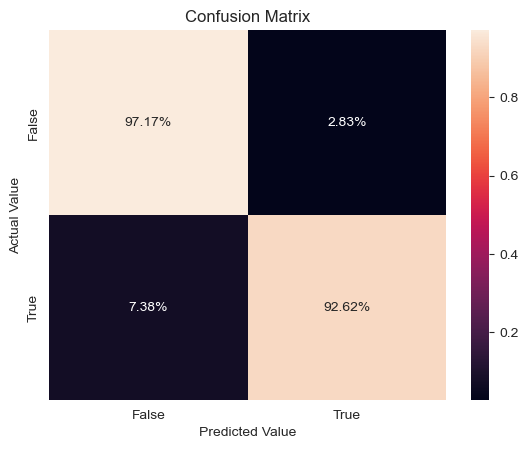

In [38]:
# Standardized knn model with 5 neighbors
knn_scaler_5 = KNeighborsClassifier(n_neighbors=5)
knn_scaler_5.fit(x_train_scaled, y_train_scaled)
knn_scaler_5_pred = knn_scaler_5.predict(x_test_scaled)

# plot the confusion matrix
cm_5 = confusion_matrix(y_test_scaled, knn_scaler_5_pred, normalize='true')
cm_plt = sns.heatmap(cm_5, annot=True, fmt=".2%")
cm_plt.set_title("Confusion Matrix")
cm_plt.set_xlabel("Predicted Value")
cm_plt.set_ylabel("Actual Value")
cm_plt.xaxis.set_ticklabels(["False", "True"])
cm_plt.yaxis.set_ticklabels(["False", "True"])
plt.show()

In [39]:
# compute the accuracy and error rate
accuracy = accuracy_score(y_test_scaled, knn_scaler_5_pred)
error_knn_scaled_5 = 1 - accuracy
print(f"The error rate is {error_knn_scaled_5}, suggesting we misclassified {error_knn_scaled_5*100:.2f}% of the data.")

The error rate is 0.047091412742382266, suggesting we misclassified 4.71% of the data.


In [29]:
# compute the true positive rate
total_obs = y_test_scaled.shape[0]
scale_no_norm = confusion_matrix(y_test_scaled, knn_scaler_5_pred)
true_positives = scale_no_norm[1,1]/(y_test_scaled==1).sum()
true_positive_rate = true_positives * 100
print(f"{true_positive_rate:.2f} percent of the firms predicted to evade their taxes actually evaded taxes.")

90.57 percent of the firms predicted to evade their taxes actually evaded taxes.


The model without the predictors normalized performs better. It has lower error rate, lower false negative rate and higher true positive rate. The false negative rate for the not normalized model is about 2.5% lower than the normalized model, suggesting a better model performance in this scenario.

### Model Tuning
k = 3 yields the lowest error rate.

In [42]:
# use grid search method to find the best knn neighbors value
ks = list(range(1, 21, 1))
para = {'n_neighbors': ks}
knni = KNeighborsClassifier()
kfcv = KFold(n_splits=5, random_state=13, shuffle=True)
knn_cv = GridSearchCV(knni, para, cv=kfcv)
knn_cv.fit(X_train, y_train)
knn_cv_pred = knn_cv.predict(X_test)
knn_cv_pred_acc = accuracy_score(y_test, knn_cv_pred)
knn_cv_error = 1-knn_cv_pred_acc

print("Best parameters:", knn_cv.best_params_)
print("Best cross-validation score:", knn_cv.best_score_)
print("Error rate:", knn_cv_error)

Best parameters: {'n_neighbors': 3}
Best cross-validation score: 0.961111111111111
Error rate: 0.03601108033240996


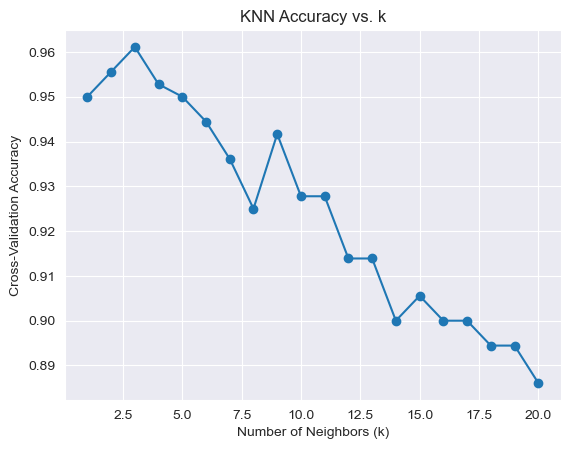

In [45]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

ks = list(range(1, 21, 1))
cv_scores = []  # Store cross-validation scores


# plot the cross_validation score with corresponding k neighbors
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=kfcv)
    cv_scores.append(scores.mean())

plt.plot(ks, cv_scores, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("KNN Accuracy vs. k")
plt.show()

#### Logistic Regression Model


In [47]:
# train logistic regression model with 30-70 split
train_data, test_data = train_test_split(file, test_size=0.3, random_state=42)
X_train = train_data.drop(columns=['Risk'])
y_train = train_data['Risk']
X_test = test_data.drop(columns=['Risk'])
y_test = test_data['Risk']

logitRegr = LogisticRegression()
logitRegr.fit(X_train, y_train)

# set decision threshold at 0.5
y_prob = logitRegr.predict_proba(X_test)[:,1]
y_pred = (y_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
test_error = 1- accuracy
print(f'The error rate of the model is: {test_error*100:.2f}%')

The error rate of the model is: 0.92%


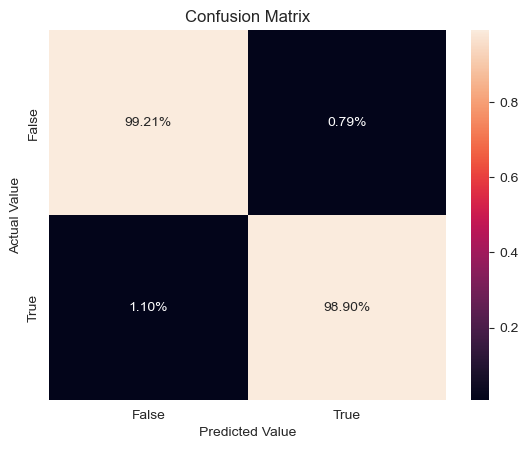

In [48]:
cm_log = confusion_matrix(y_test, y_pred, normalize='true')
cm_plt = sns.heatmap(cm_log, annot=True, fmt=".2%")
cm_plt.set_title("Confusion Matrix")
cm_plt.set_xlabel("Predicted Value")
cm_plt.set_ylabel("Actual Value")
cm_plt.xaxis.set_ticklabels(["False", "True"])
cm_plt.yaxis.set_ticklabels(["False", "True"])
plt.show()

The logistic regression model gives a overall error rate of 0.0092 with false negative rate of 1.1%.

### Problem Addressing
A major problem is selection bias. The data only includes firms that were audited. We don't know the performance of firms that were not audited. If government relied on this model, it may lead to audits being concentrated on firms that resemble past audited firm, even if they are not fraudulent. Also, if there's new fraud pattern, the model may fail to detect it.